In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy import stats
from theano import tensor as tt

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [2]:
az.style.use("arviz-darkgrid")

# Chapter 15 - The SIMPLE model of memory

## 15.1 The SIMPLE model
Brown, Neath, and Chater (2007) proposed the SIMPLE (Scale-Invariant Memory, Perception, and LEarning) model, which, among various applications, has been applied to the basic memory phenomenon of free recall.

$$ c_x \sim \text{Uniform}(0,100)$$
$$ s_x \sim \text{Uniform}(0,100)$$
$$ t_x \sim \text{Uniform}(0,1) $$  
$$ \eta_{ijx} = \text{exp}(-\,c_x \,\lvert \text{log} T_{ix}\,-\,\text{log} T_{jx}\rvert)$$  
$$ d_{ijx} = \frac{\eta_{ijx}} {\sum_{k}\eta_{ikx}}$$  
$$ r_{ijx} = \frac{1} {1\,+\,\text{exp}(-\,s_{x}(d_{ijx}\,-\,t_{x}))}$$  
$$ \theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$$
$$ y_{ix} \sim \text{Binomial}(\theta_{ix},\eta_{x})$$

Model correction on SIMPLE model could be done by replacing $\theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$ with $\theta_{ix} = 1\,-\,\prod_{k}(1-r_{ikx})$ (see Box 15.2 on page 200)

In [3]:
y = pd.read_csv("data/k_M.txt", ",", header=None)
n = np.array([1440, 1280, 1520, 1520, 1200, 1280])
listlength = np.array([10, 15, 20, 20, 30, 40])
lagall = np.array([2, 2, 2, 1, 1, 1])
offset = np.array([15, 20, 25, 10, 15, 20])
dsets = 6
m = np.zeros(np.shape(y))

for i in range(dsets):
    m[i, 0 : listlength[i]] = offset[i] + np.arange((listlength[i]) * lagall[i], 0, -lagall[i])

pc = pd.read_csv("data/pc_M.txt", ",", header=None)
pcmat = np.asarray(pc).T

In [4]:
ymat = np.asarray(y)
nitem = m.shape[1]
m2 = m
m2[m2 == 0] = 1e-5  # to avoid NaN in ADVI
nmat = np.repeat(n[:, np.newaxis], nitem, axis=1)
mmat1 = np.repeat(m2[:, :, np.newaxis], nitem, axis=2)
mmat2 = np.transpose(mmat1, (0, 2, 1))
mask = np.where(ymat > 0)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 33100
Interrupted at 33,099 [16%]: Average Loss = 30,232
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tx, sx, cx]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 343 seconds.


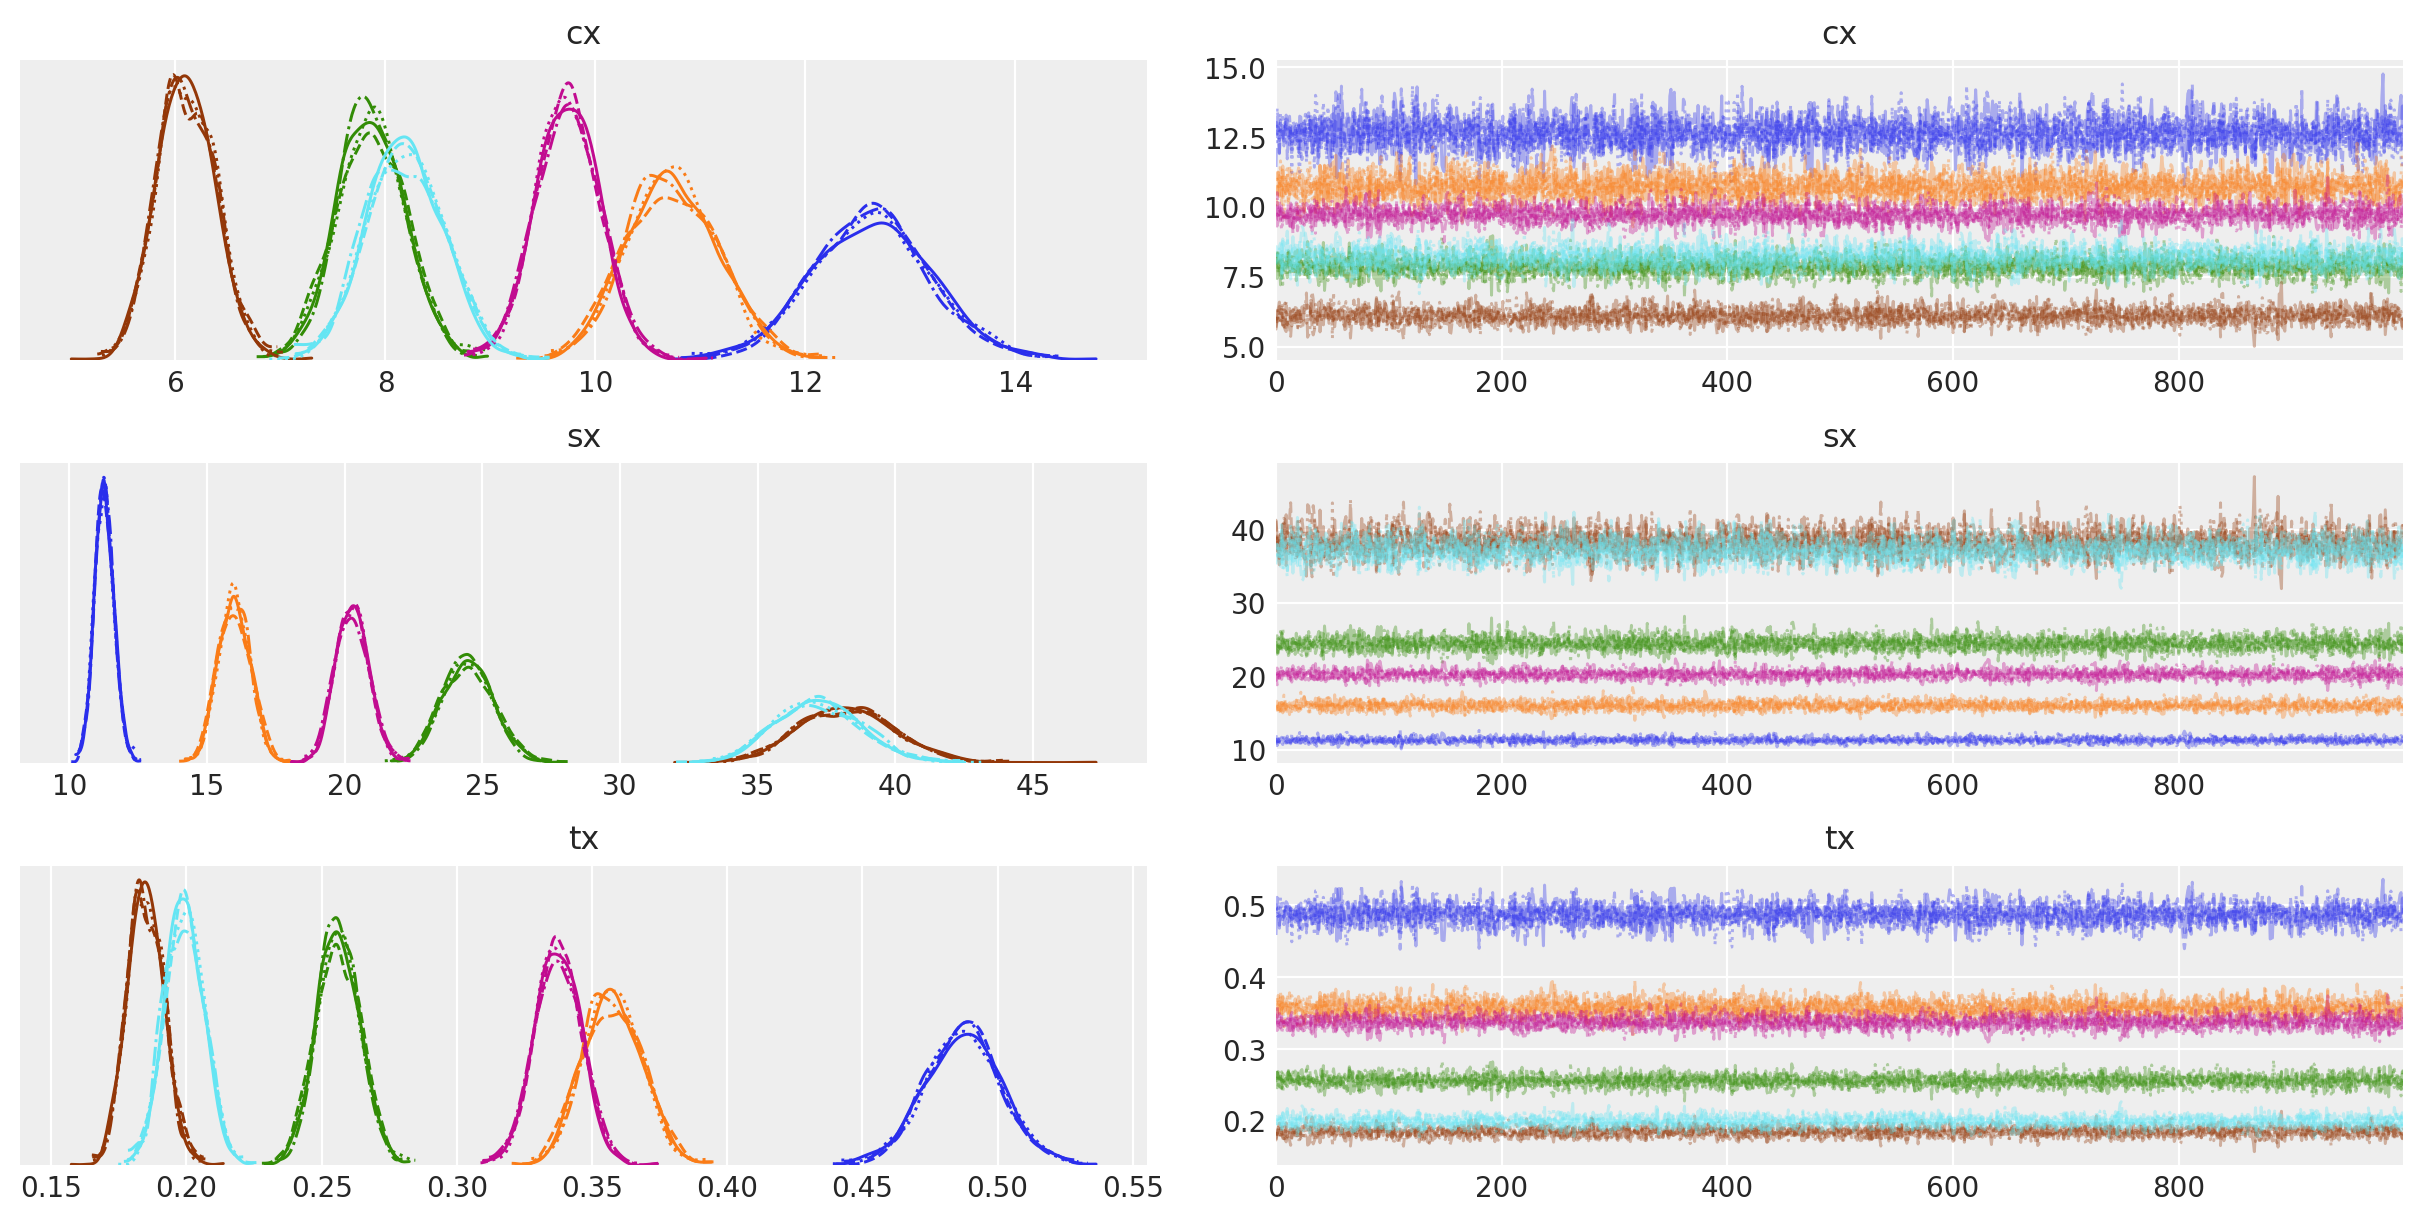

In [5]:
with pm.Model() as simple1:
    cx = pm.Uniform("cx", lower=0, upper=100, shape=dsets, testval=np.ones(dsets) * 20)
    sx = pm.Uniform("sx", lower=0, upper=100, shape=dsets)
    tx = pm.Uniform("tx", lower=0, upper=1, shape=dsets)

    # Similarities
    eta = tt.exp(-cx[:, np.newaxis, np.newaxis] * abs(tt.log(mmat1) - tt.log(mmat2)))
    etasum = tt.reshape(tt.repeat(tt.sum(eta, axis=2), nitem), (dsets, nitem, nitem))

    # Discriminabilities
    disc = eta / etasum

    # Response Probabilities
    resp = 1 / (1 + tt.exp(-sx[:, np.newaxis, np.newaxis] * (disc - tx[:, np.newaxis, np.newaxis])))

    # Free Recall Overall Response Probability
    # theta = tt.clip(tt.sum(resp, axis=2), 0., .999)
    theta = 1 - tt.prod(1 - resp, axis=2)

    yobs = pm.Binomial("yobs", p=theta[mask], n=nmat[mask], observed=ymat[mask])
    trace = pm.sample(init="advi+adapt_diag")

az.plot_trace(trace, var_names=["cx", "sx", "tx"], compact=True);

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 34600
Interrupted at 34,599 [17%]: Average Loss = 60,885
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tx, sx, cx]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 380 seconds.


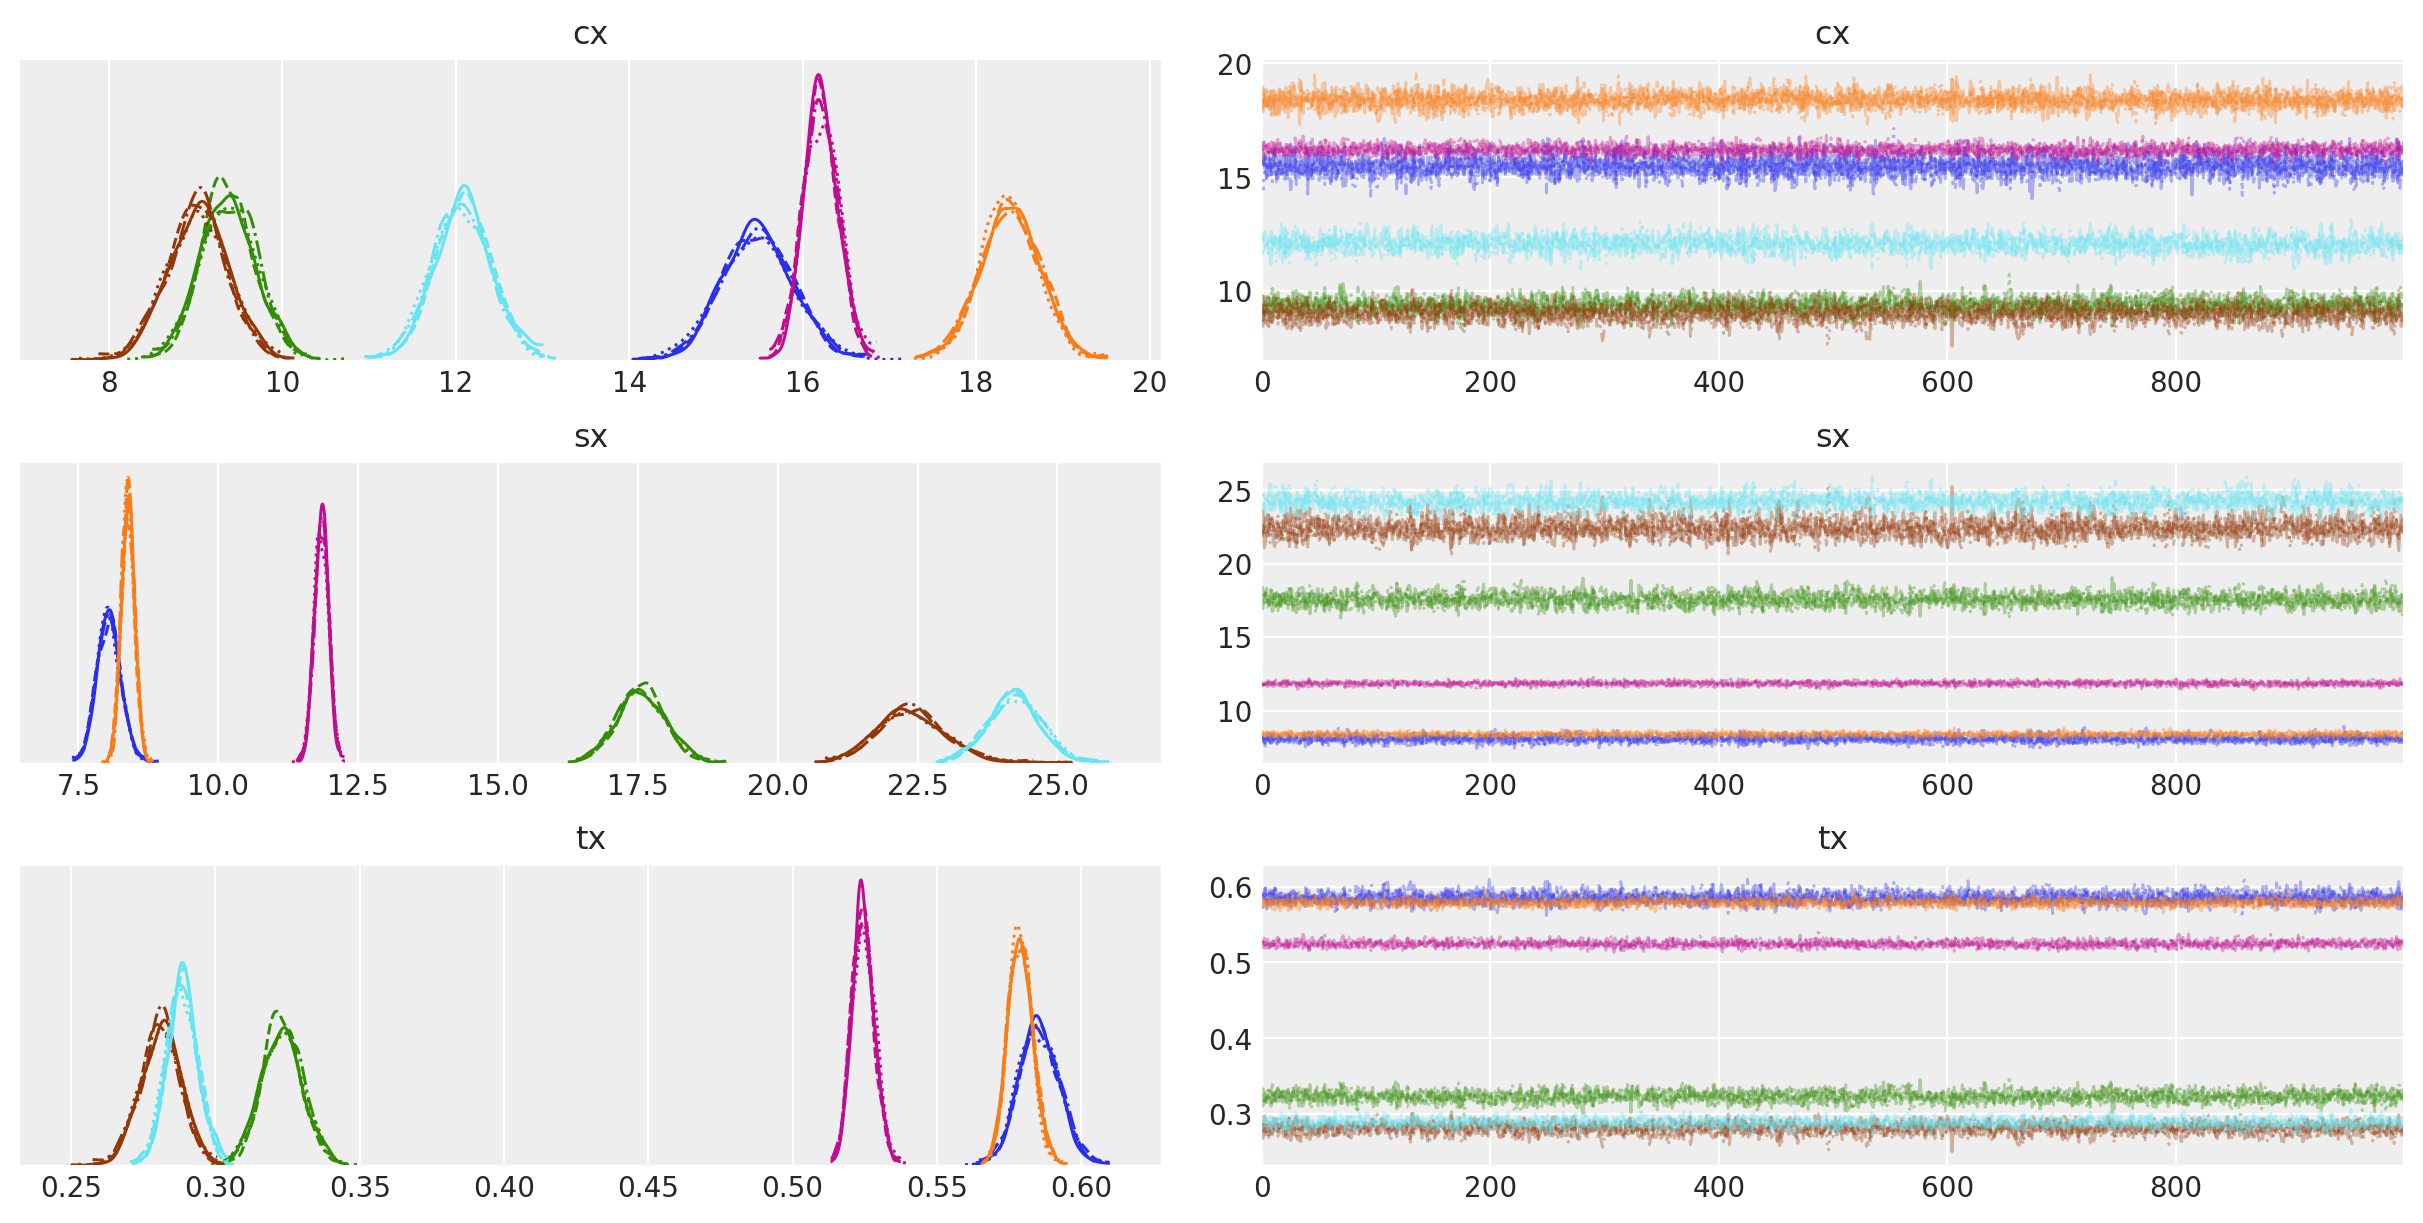

In [6]:
ymat = np.asarray(y).T
mmat = m.T

with pm.Model() as simple1:
    cx = pm.Uniform("cx", lower=0, upper=100, shape=dsets, testval=np.ones(dsets) * 20)
    sx = pm.Uniform("sx", lower=0, upper=100, shape=dsets)
    tx = pm.Uniform("tx", lower=0, upper=1, shape=dsets)

    yobs = []
    for x in range(dsets):
        sz = listlength[x]
        # Similarities
        m1 = np.array([mmat[0:sz, x]] * sz).T
        m2 = np.array([mmat[0:sz, x]] * sz)

        eta = tt.exp(-cx[x] * abs(tt.log(m1) - tt.log(m2)))
        etasum = tt.reshape(tt.repeat(tt.sum(eta, axis=1), sz), (sz, sz))
        # Discriminabilities
        disc = eta / etasum
        # Response Probabilities
        resp = 1 / (1 + tt.exp(-sx[x] * (disc - tx[x])))
        # Free Recall Overall Response Probability
        theta = tt.clip(tt.sum(resp, axis=1), 0, 0.999)
        # theta=1-tt.prod(1-resp,axis=1)

        yobs.append([pm.Binomial("yobs_%x" % x, p=theta, n=n[x], observed=ymat[0:sz, x])])

    trace = pm.sample(tune=2000, init="advi+adapt_diag", target_accept=0.95)

az.plot_trace(trace, var_names=["cx", "sx", "tx"], compact=True);

The above two models do the same thing, but surprisingly using list compression is actually faster.

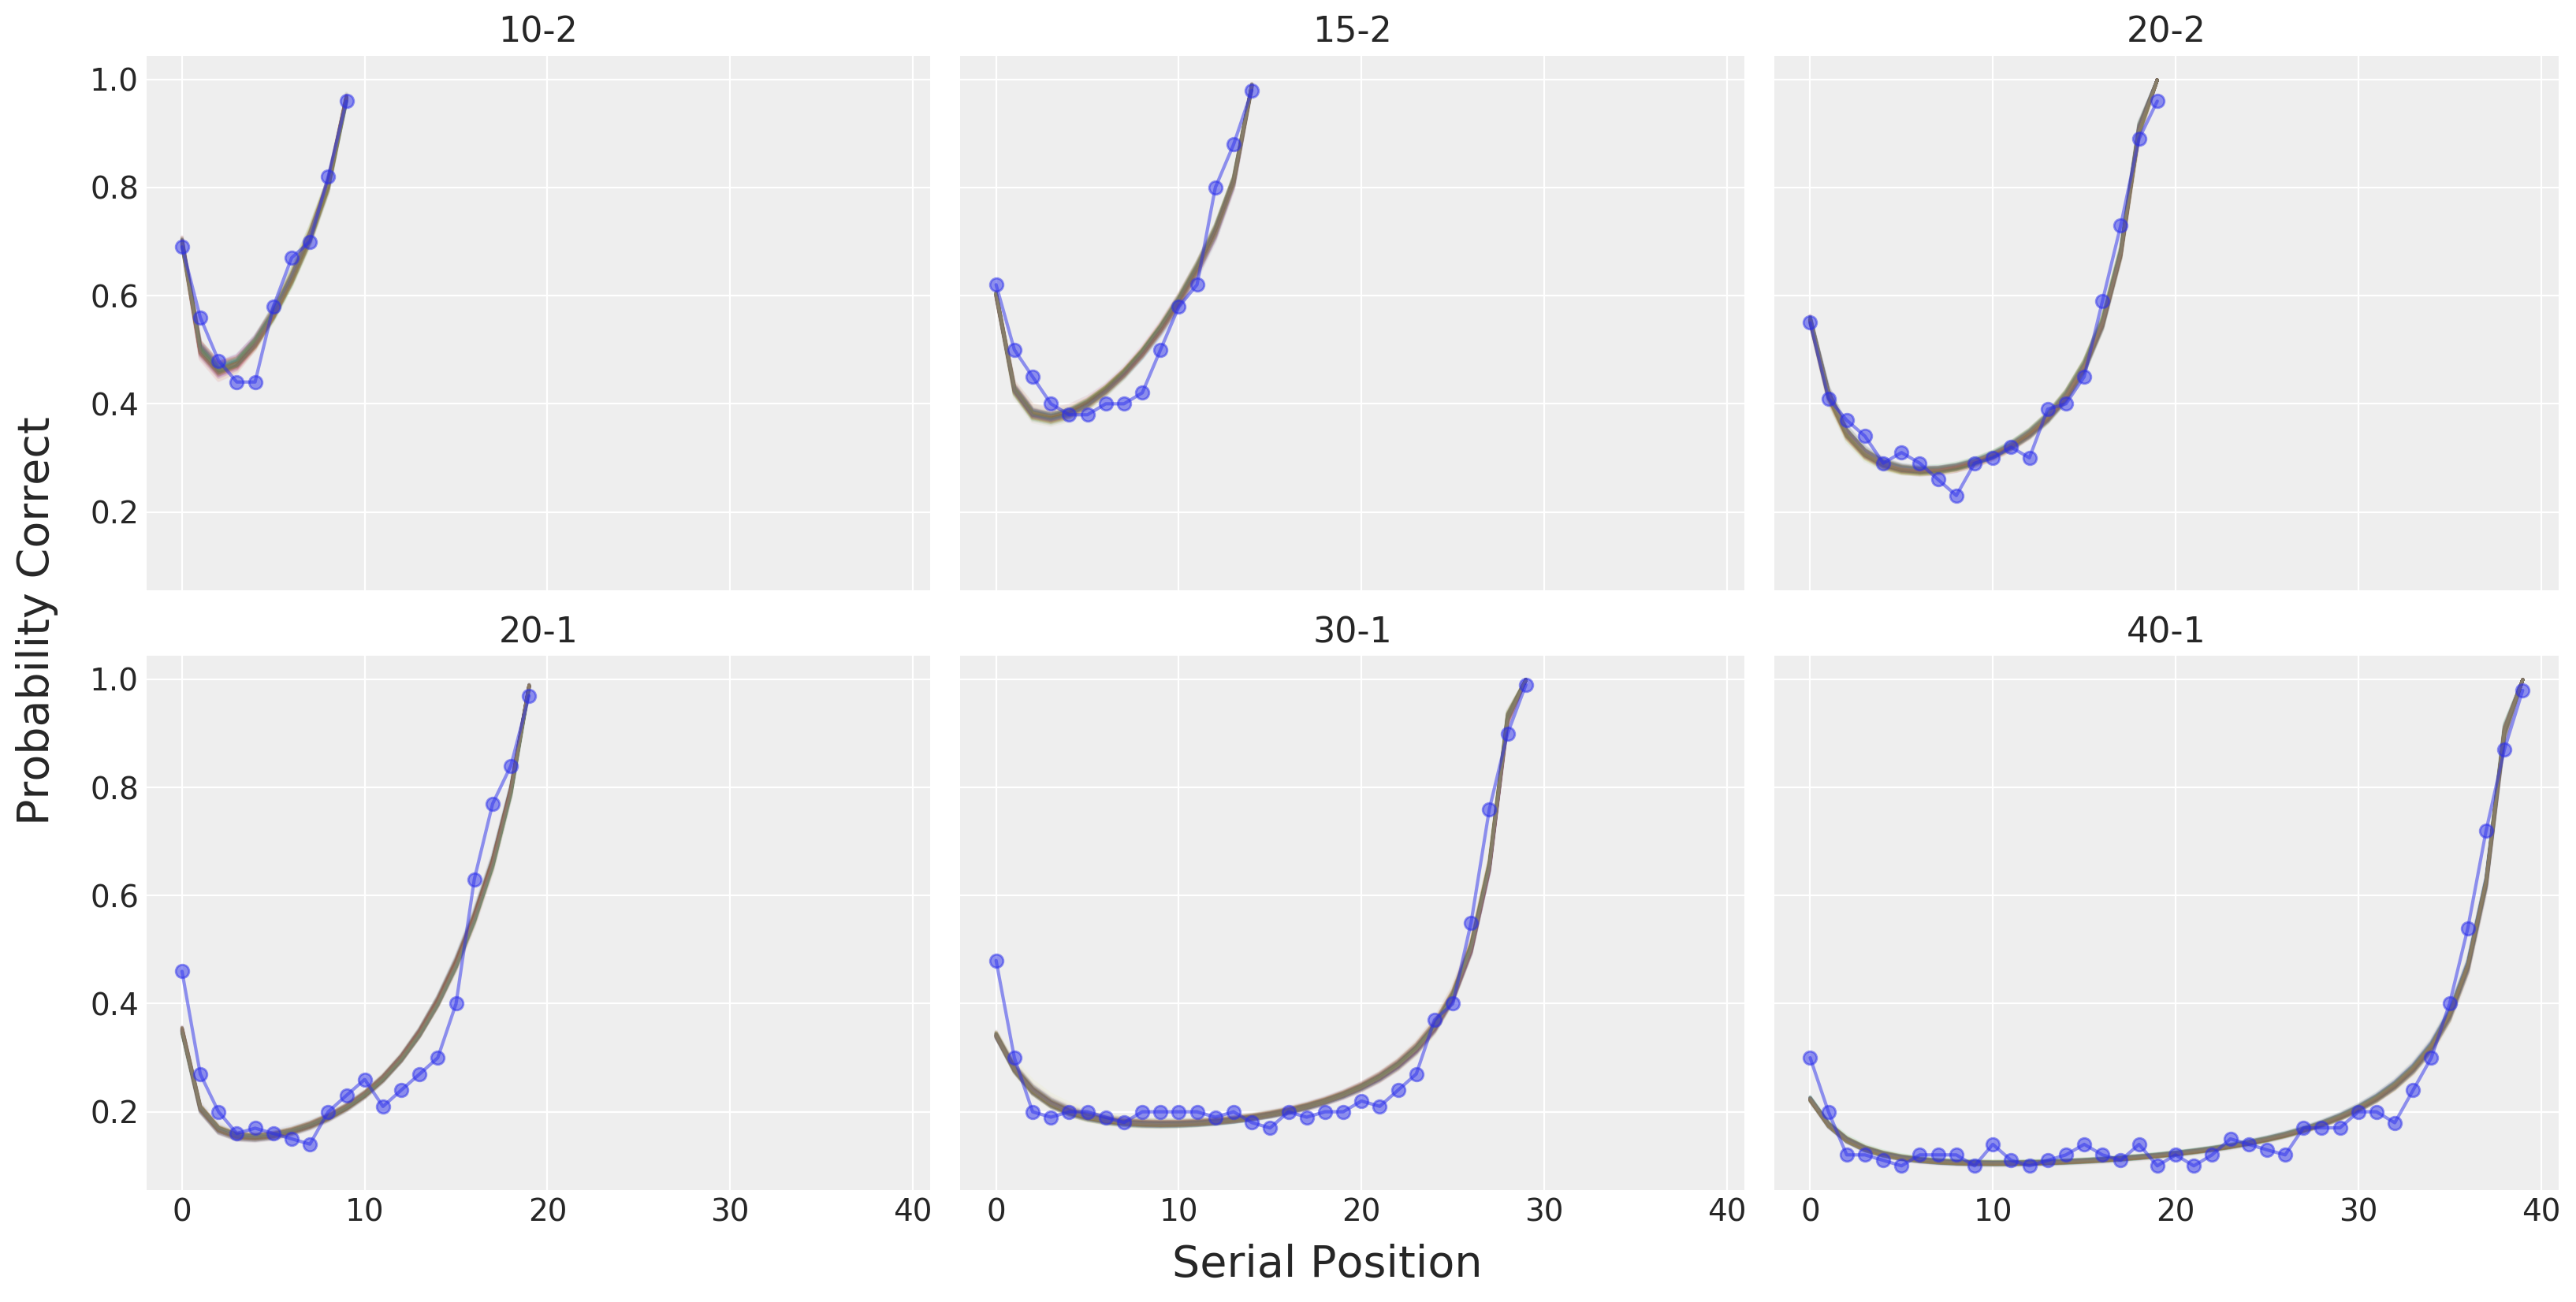

In [7]:
ymat = np.asarray(y).T
mmat = m.T

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
gs = axes.flatten()
fig.text(0.5, -0.02, "Serial Position", ha="center", fontsize=20)
fig.text(-0.02, 0.5, "Probability Correct", va="center", rotation="vertical", fontsize=20)

burnin = 0
totalsamp = 1000
ppcsamples = 200

for ip in range(dsets):
    ax = gs[ip]
    ay = ymat[:, ip] / n[ip]  # pcmat[:,ip]

    cxt = trace["cx"][:, ip]
    sxt = trace["sx"][:, ip]
    txt = trace["tx"][:, ip]

    sz = listlength[ip]
    # Similarities
    m1 = np.array([mmat[0:sz, ip]] * sz).T
    m2 = np.array([mmat[0:sz, ip]] * sz)
    for ips in np.random.randint(burnin, totalsamp, ppcsamples):

        eta = np.exp(-cxt[ips] * abs(np.log(m1) - np.log(m2)))
        etasum = np.reshape(np.repeat(np.sum(eta, axis=1), sz), (sz, sz))
        # Discriminabilities
        disc = eta / etasum
        # Response Probabilities
        resp = 1 / (1 + np.exp(-sxt[ips] * (disc - txt[ips])))
        # Free Recall Overall Response Probability
        theta = np.minimum(np.sum(resp, axis=1), 0.999)
        ax.plot(theta, alpha=0.05)

    ax.plot(ay[ay != 0], marker="o", alpha=0.5)
    ax.set_title(str(listlength[ip]) + "-" + str(lagall[ip]))

plt.tight_layout();

## 15.2 A hierarchical extension of SIMPLE


$$ c \sim \text{Uniform}(0,100)$$
$$ s \sim \text{Uniform}(0,100)$$
$$ a_{1} \sim \text{Uniform}(-1,0) $$
$$ a_{2} \sim \text{Uniform}(0,1) $$
$$ t_x = a_{1}W_x + a_{2} $$  
$$ \eta_{ijx} = \text{exp}(-\,c_x \,\lvert \text{log} T_{ix}\,-\,\text{log} T_{jx}\rvert)$$  
$$ d_{ijx} = \frac{\eta_{ijx}} {\sum_{k}\eta_{ikx}}$$  
$$ r_{ijx} = \frac{1} {1\,+\,\text{exp}(-\,s_{x}(d_{ijx}\,-\,t_{x}))}$$  
$$ \theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$$
$$ y_{ix} \sim \text{Binomial}(\theta_{ix},\eta_{x})$$

Model correction on SIMPLE model could be done by replacing $\theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$ with $\theta_{ix} = 1\,-\,\prod_{k}(1-r_{ikx})$ (see Box 15.2 on page 200)

In [8]:
ymat = np.asarray(y)
nitem = m.shape[1]
m2 = m
m2[m2 == 0] = 1e-5  # to avoid NaN in ADVI
nmat = np.repeat(n[:, np.newaxis], nitem, axis=1)
mmat1 = np.repeat(m2[:, :, np.newaxis], nitem, axis=2)
mmat2 = np.transpose(mmat1, (0, 2, 1))
mask = np.where(ymat > 0)
W = listlength

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a2, a1, sx, cx]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 322 seconds.
The number of effective samples is smaller than 25% for some parameters.


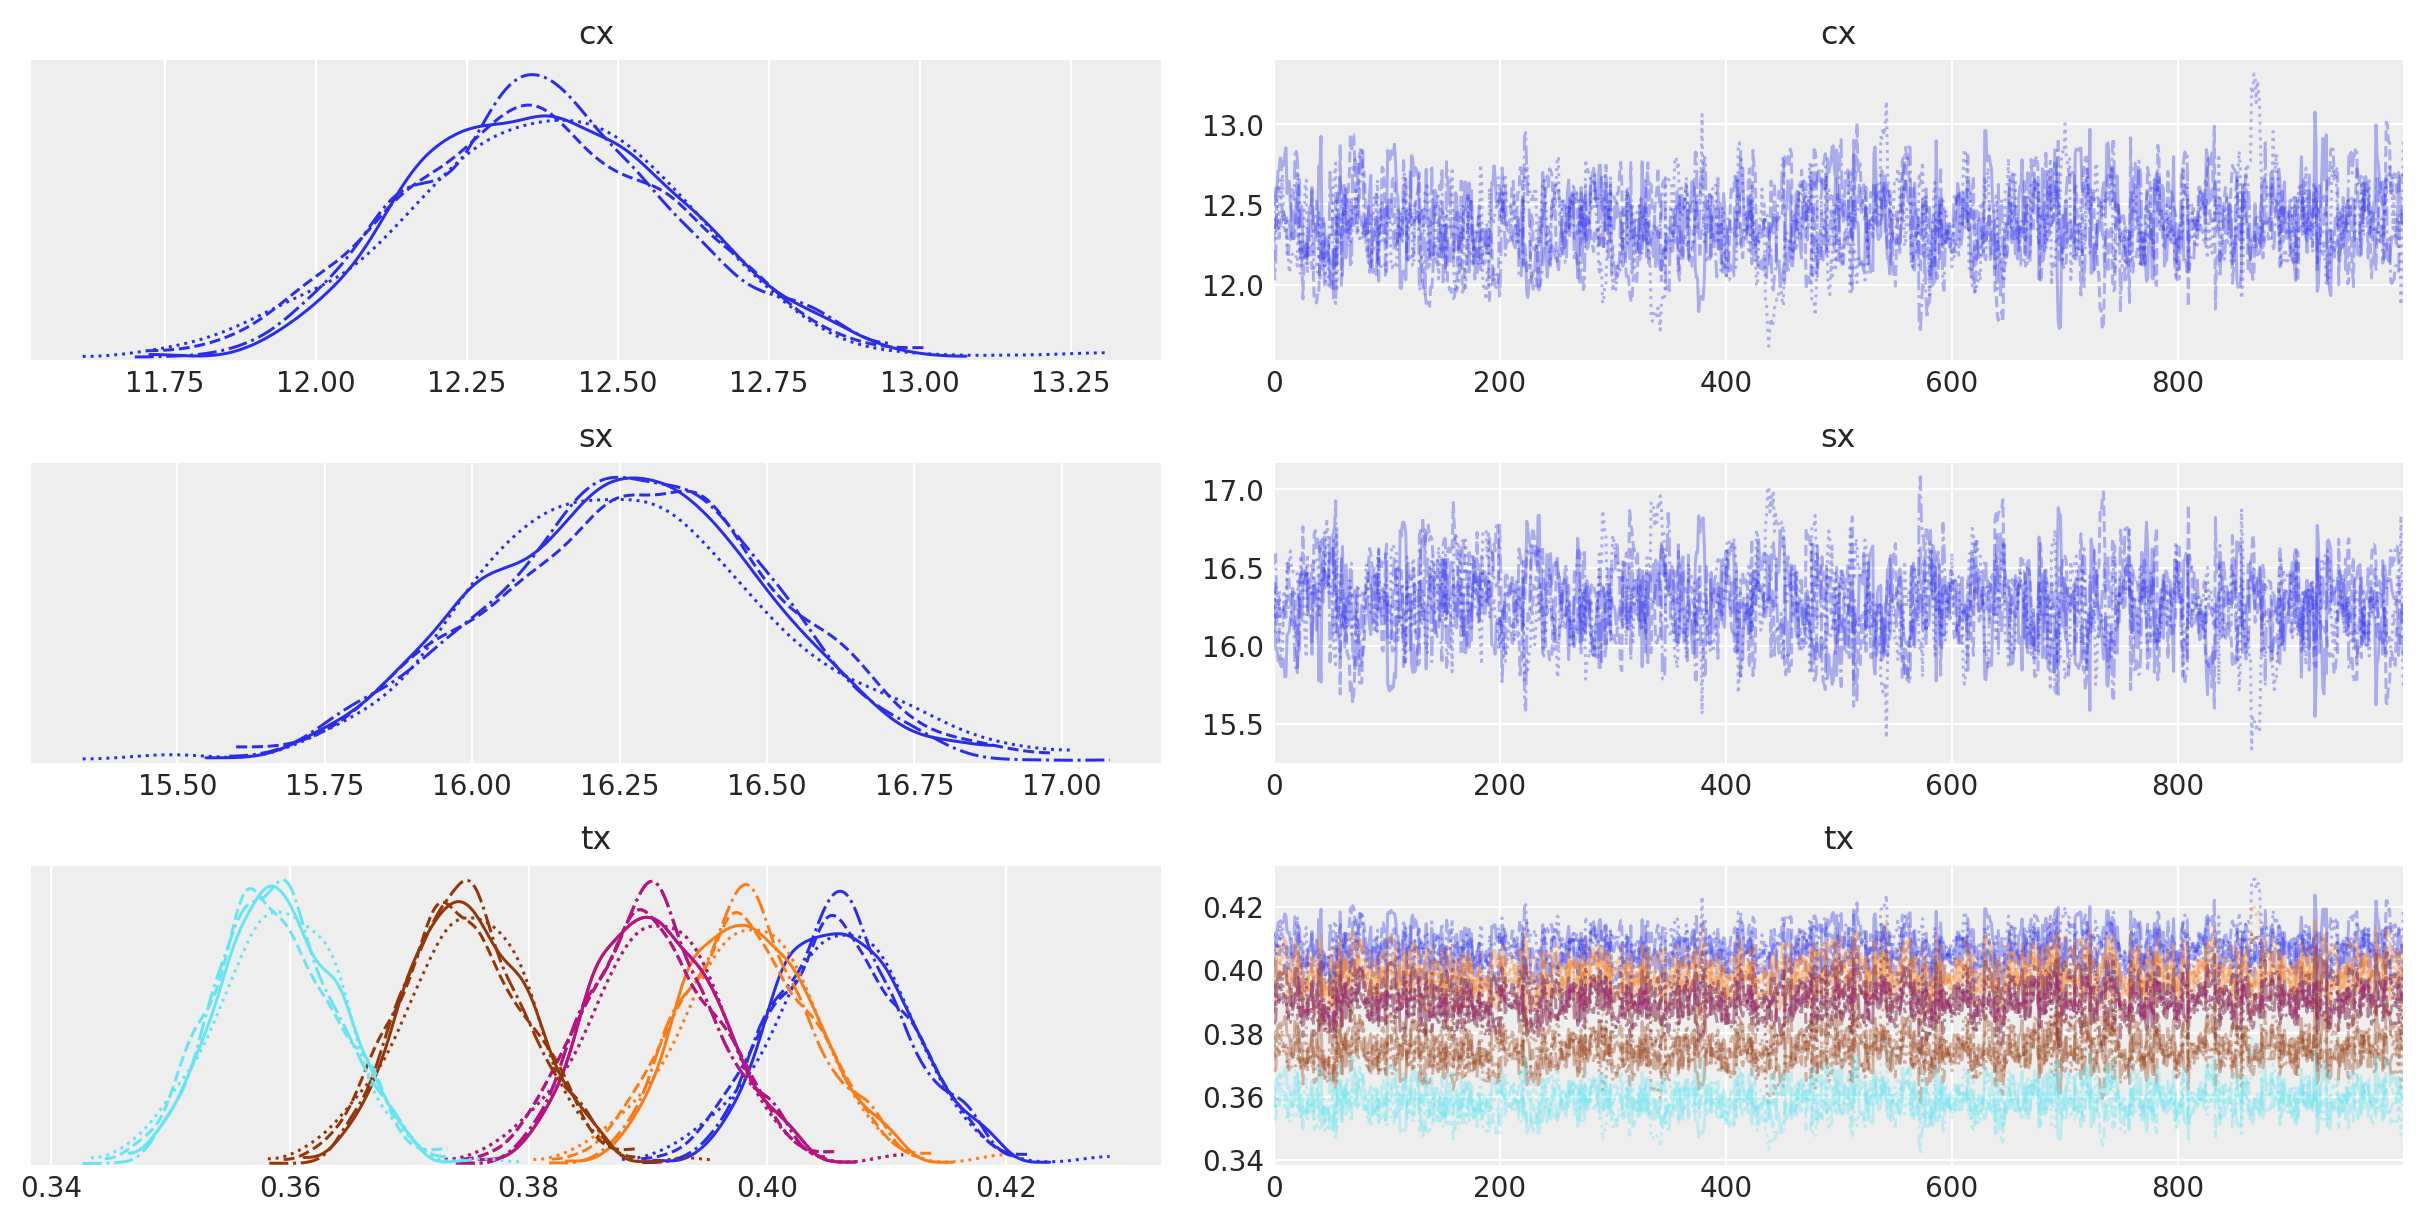

In [9]:
with pm.Model() as simple2:
    cx = pm.Uniform("cx", lower=0, upper=100, testval=21)
    sx = pm.Uniform("sx", lower=0, upper=100, testval=10)
    a1 = pm.Uniform("a1", lower=-1, upper=0, testval=-0.002)
    a2 = pm.Uniform("a2", lower=0, upper=1, testval=0.64)
    tx = pm.Deterministic("tx", a1 * W + a2)

    # Similarities
    eta = tt.exp(-cx * abs(tt.log(mmat1) - tt.log(mmat2)))
    etasum = tt.reshape(tt.repeat(tt.sum(eta, axis=2), nitem), (dsets, nitem, nitem))

    # Discriminabilities
    disc = eta / etasum

    # Response Probabilities
    resp = 1 / (1 + tt.exp(-sx * (disc - tx[:, np.newaxis, np.newaxis])))

    # Free Recall Overall Response Probability
    # theta = tt.clip(tt.sum(resp, axis=2), 0., .999)
    theta = 1 - tt.prod(1 - resp, axis=2)

    yobs = pm.Binomial("yobs", p=theta[mask], n=nmat[mask], observed=ymat[mask])
    trace2_ = pm.sample(tune=3000, init="adapt_diag", target_accept=0.95)

az.plot_trace(trace2_, var_names=["cx", "sx", "tx"], compact=True);

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 13600
Interrupted at 13,599 [6%]: Average Loss = 1.0737e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a2, a1, sx, cx]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


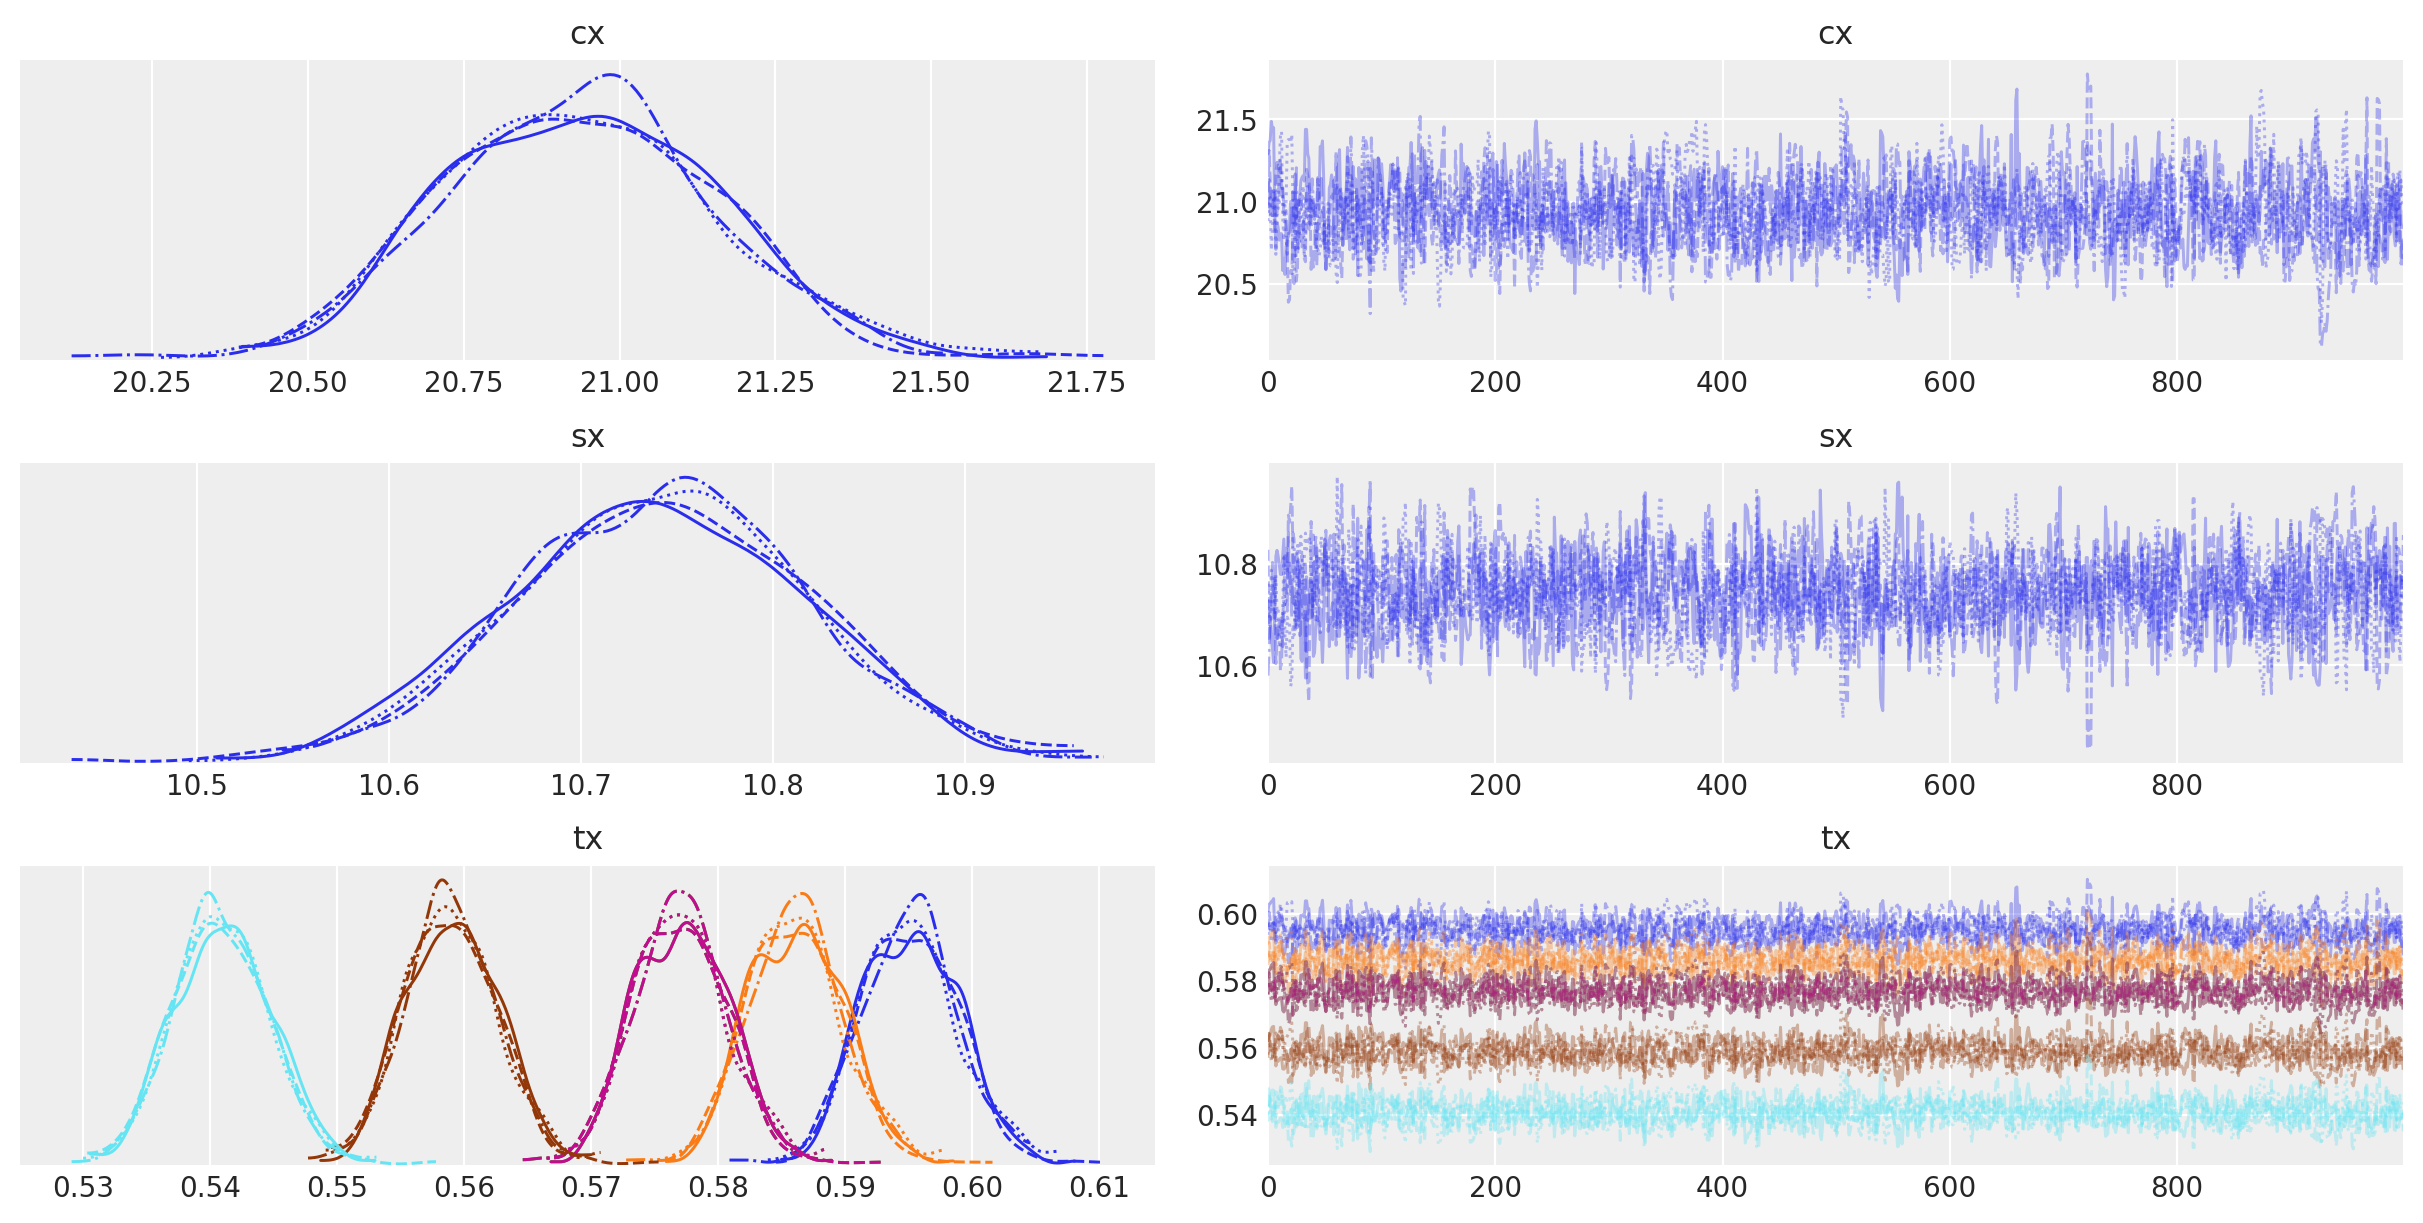

In [10]:
ymat = np.asarray(y).T
mmat = m.T
W = listlength

with pm.Model() as simple2:
    cx = pm.Uniform("cx", lower=0, upper=100, testval=21)
    sx = pm.Uniform("sx", lower=0, upper=100, testval=10)
    a1 = pm.Uniform("a1", lower=-1, upper=0, testval=-0.002)
    a2 = pm.Uniform("a2", lower=0, upper=1, testval=0.64)
    tx = pm.Deterministic("tx", a1 * W + a2)

    yobs = []
    for x in range(dsets):
        sz = listlength[x]
        # Similarities
        m1 = np.array([mmat[0:sz, x]] * sz).T
        m2 = np.array([mmat[0:sz, x]] * sz)

        eta = tt.exp(-cx * abs(tt.log(m1) - tt.log(m2)))
        etasum = tt.reshape(tt.repeat(tt.sum(eta, axis=1), sz), (sz, sz))
        # Discriminabilities
        disc = eta / etasum
        # Response Probabilities
        resp = 1 / (1 + tt.exp(-sx * (disc - tx[x])))
        # Free Recall Overall Response Probability
        theta = tt.clip(tt.sum(resp, axis=1), 0, 0.999)
        # theta=1-tt.prod(1-resp,axis=1)

        yobs.append([pm.Binomial("yobs_%x" % x, p=theta, n=n[x], observed=ymat[0:sz, x])])

    trace2 = pm.sample(init="advi+adapt_diag")

az.plot_trace(trace2, var_names=["cx", "sx", "tx"], compact=True);

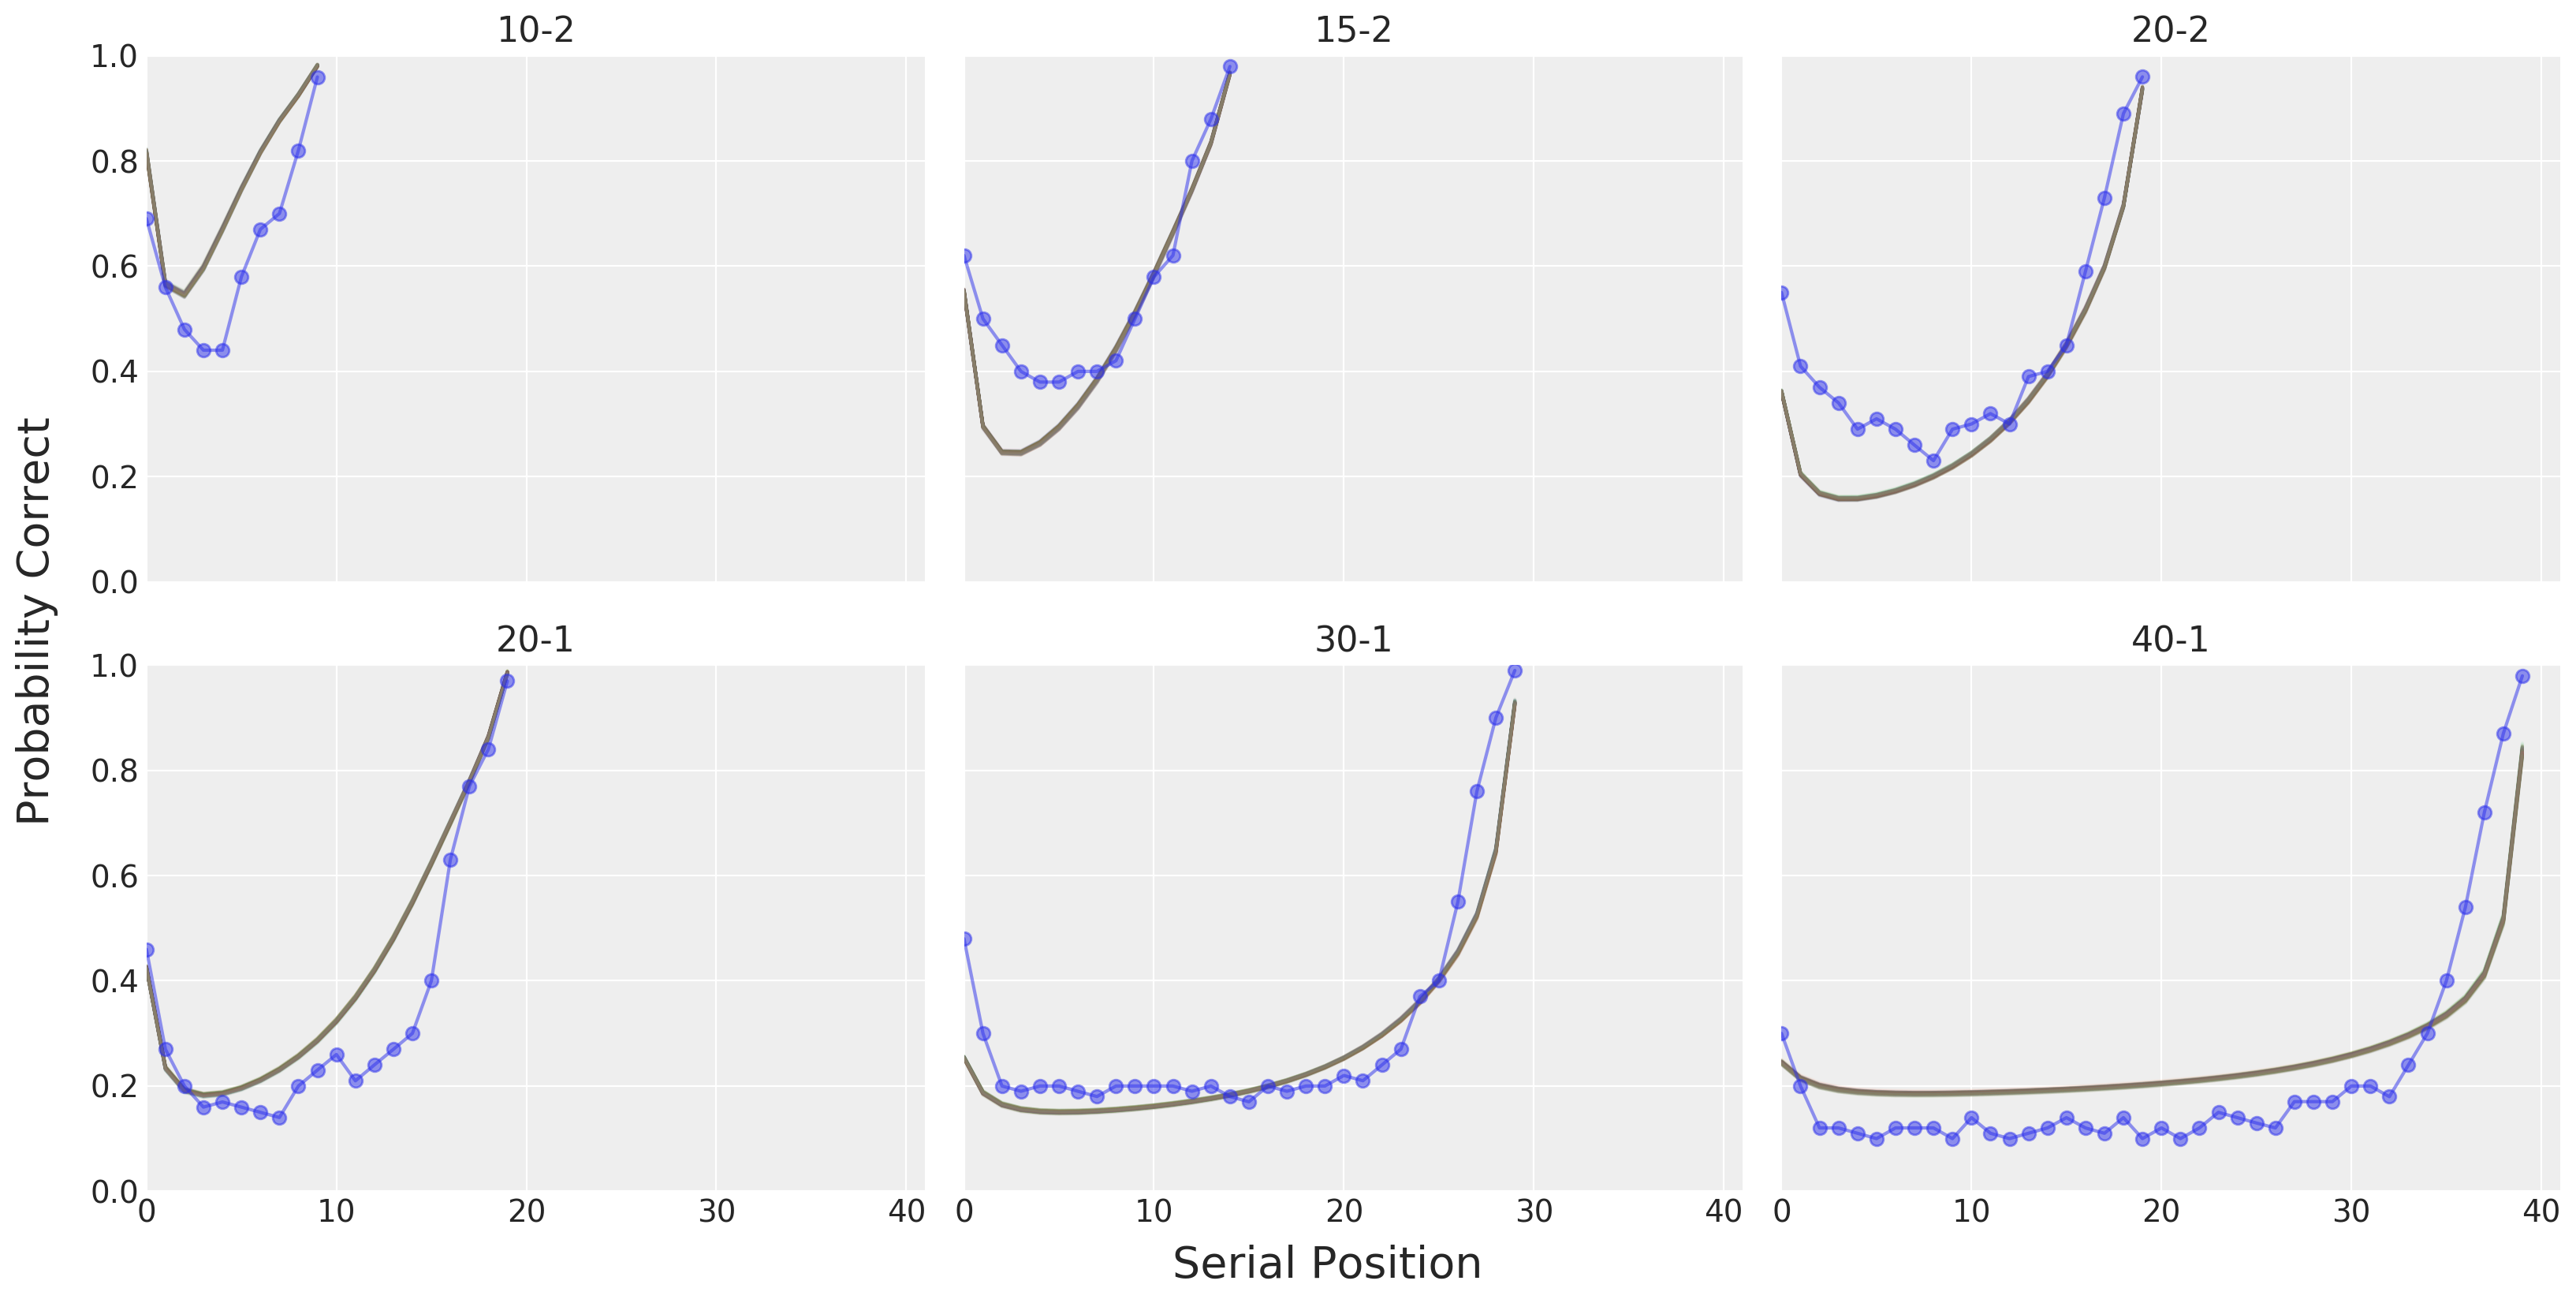

In [11]:
trace = trace2

ymat = np.asarray(y).T
mmat = m.T

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
gs = axes.flatten()
fig.text(0.5, -0.02, "Serial Position", ha="center", fontsize=20)
fig.text(-0.02, 0.5, "Probability Correct", va="center", rotation="vertical", fontsize=20)

burnin = 0
totalsamp = 1000
ppcsamples = 200

for ip in range(dsets):
    ax = gs[ip]
    ay = ymat[:, ip] / n[ip]  # pcmat[:,ip]

    cxt = trace["cx"]
    sxt = trace["sx"]
    txt = trace["tx"][:, ip]

    sz = listlength[ip]
    # Similarities
    m1 = np.array([mmat[0:sz, ip]] * sz).T
    m2 = np.array([mmat[0:sz, ip]] * sz)
    for ips in np.random.randint(burnin, totalsamp, ppcsamples):

        eta = np.exp(-cxt[ips] * abs(np.log(m1) - np.log(m2)))
        etasum = np.reshape(np.repeat(np.sum(eta, axis=1), sz), (sz, sz))
        # Discriminabilities
        disc = eta / etasum
        # Response Probabilities
        resp = 1 / (1 + np.exp(-sxt[ips] * (disc - txt[ips])))
        # Free Recall Overall Response Probability
        theta = np.minimum(np.sum(resp, axis=1), 0.999)
        ax.plot(theta, alpha=0.05)

    ax.plot(ay[ay != 0], marker="o", alpha=0.5)
    ax.axis((0, 41, 0, 1))
    ax.set_title(str(listlength[ip]) + "-" + str(lagall[ip]))

plt.tight_layout();

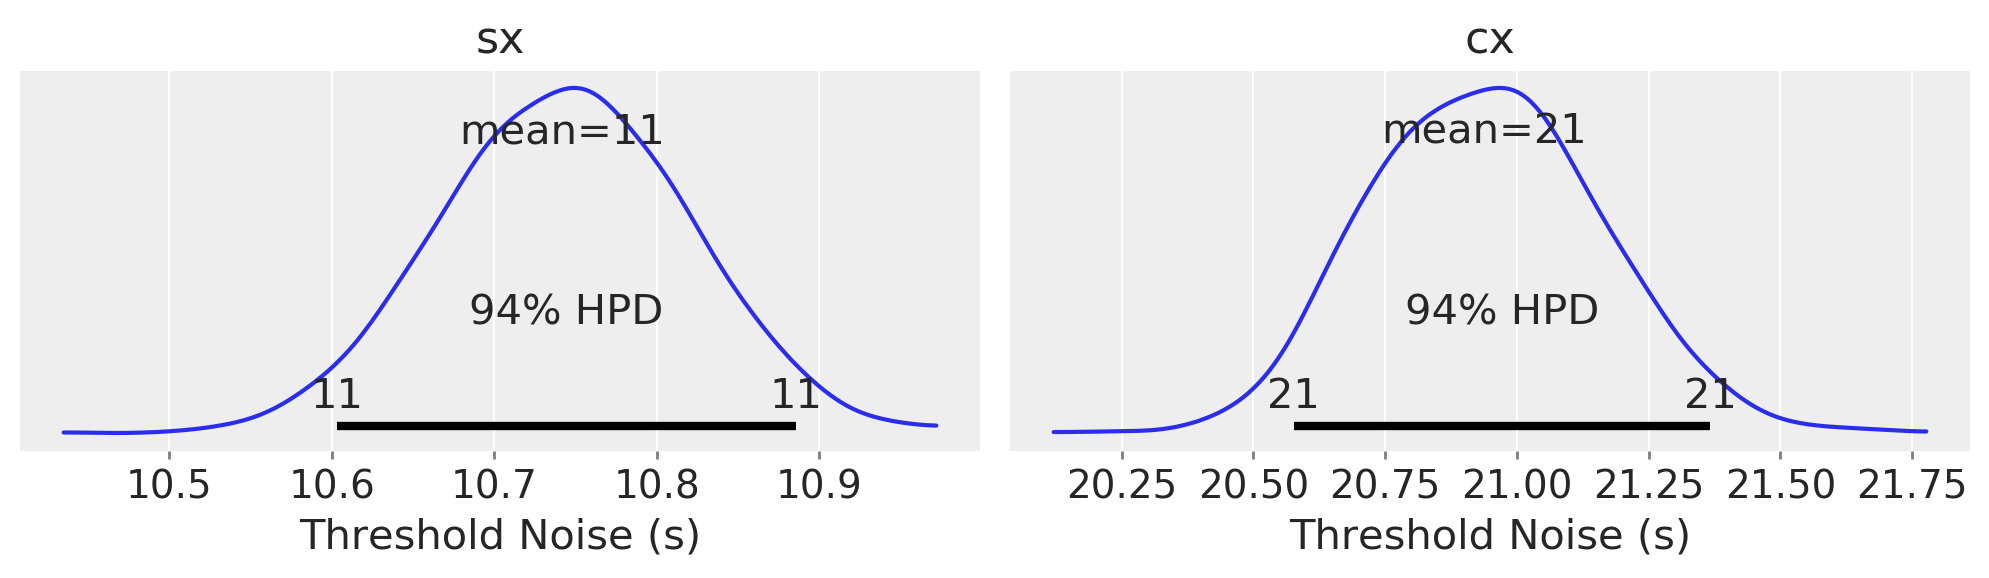

In [12]:
fig = plt.figure(figsize=(15, 3))

ax1 = plt.subplot(1, 3, 1)
az.plot_posterior(trace, var_names=["sx"], ax=ax1)
ax1.set_xlabel("Threshold Noise (s)")

ax2 = plt.subplot(1, 3, 2)
az.plot_posterior(trace, var_names=["cx"], ax=ax2)
ax2.set_xlabel("Threshold Noise (s)")
plt.tight_layout();

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

pandas 1.0.3
numpy  1.18.1
arviz  0.7.0
pymc3  3.8
last updated: Tue Apr 28 2020 

CPython 3.7.7
IPython 7.13.0
watermark 2.0.2
